# **1. Entendimento do Negócio**

## - **Objetivo:** O projeto tem como objetivo criar um modelo preditivo de scoring de crédito, prevendo a renda das pessoas para avaliar a concessão de um seguro de vida.

## - **Problema a ser resolvido:** Como garantir que o seguro seja oferecido a pessoas com perfis de risco adequados.

# **2. Entendimento dos Dados**

## - Análise detalhada dos dados, incluindo verificação de nulos, análise de outliers, identificação de tipos de dados e estatísticas descritivas. Isso é essencial para entender o que está disponível e como os dados podem ser utilizados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
import scipy.stats as stats
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LinearRegression
from scipy import stats, integrate
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

In [ ]:
# Carregar os dados
df = pd.read_feather("/content/credit_scoring.ftr")

In [ ]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [ ]:
df.isna().sum()

,0
data_ref,0
index,0
sexo,0
posse_de_veiculo,0
posse_de_imovel,0
qtd_filhos,0
tipo_renda,0
educacao,0
estado_civil,0
tipo_residencia,0


# **3. Preparação dos Dados**

## - O pré-processamento foi feito com a criação de pipelines para tratar valores ausentes, normalizar dados numéricos, aplicar one-hot encoding em variáveis categóricas e usar PCA para reduzir a dimensionalidade. Essa etapa garante que os dados estejam prontos para a modelagem.

In [ ]:
# Substituir todos os valores NaN por 0 no DataFrame
df.fillna(0, inplace=True)

In [ ]:
# Converter uma coluna específica de int para float
df['idade'] = df['idade'].astype(float)

In [ ]:
df.dtypes

,0
data_ref,datetime64[ns]
index,int64
sexo,object
posse_de_veiculo,object
posse_de_imovel,object
qtd_filhos,int64
tipo_renda,object
educacao,object
estado_civil,object
tipo_residencia,object


In [ ]:
# Instanciar o MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Aplicar o MinMaxScaler nas colunas que você quer transformar
colunas_para_transformar = ['idade', 'renda']
df[colunas_para_transformar] = scaler.fit_transform(df[colunas_para_transformar])

In [ ]:
# Identificar os três últimos meses
ultimos_3_meses = df['data_ref'].sort_values().unique()[-3:]

In [ ]:
# Definir quais são os últimos 3 meses (exemplo: você deve definir 'ultimos_3_meses' corretamente)
ultimos_3_meses = pd.date_range(end=df['data_ref'].max(), periods=3, freq='M')

# Dados de Desenvolvimento (tudo exceto os últimos 3 meses)
df_dev = df[~df['data_ref'].isin(ultimos_3_meses)]

# Dados OOT (últimos 3 meses)
df_oot = df[df['data_ref'].isin(ultimos_3_meses)]

# Remover variáveis não explicativas
colunas_para_remover = ['data_ref', 'idade']
df_dev = df_dev.drop(columns=colunas_para_remover, errors='ignore')
df_oot = df_oot.drop(columns=colunas_para_remover, errors='ignore')

# Definir variáveis explicativas e variável alvo
variaveis_explicativas = [col for col in df_dev.columns if col != 'renda']  # Excluir 'renda' das variáveis explicativas
variavel_alvo = 'renda'

# Preparar dados de desenvolvimento
X_dev = df_dev[variaveis_explicativas]
y_dev = df_dev[variavel_alvo]

# Preparar dados OOT
X_oot = df_oot[variaveis_explicativas]
y_oot = df_oot[variavel_alvo]

# Dividir dados de desenvolvimento em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)

# Verificando as formas dos conjuntos de dados
print(f'Tamanho de X_train: {X_train.shape}')
print(f'Tamanho de X_test: {X_test.shape}')
print(f'Tamanho de X_oot: {X_oot.shape}')


<ipython-input-11-5bc3ace92f3b>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ultimos_3_meses = pd.date_range(end=df['data_ref'].max(), periods=3, freq='M')


Tamanho de X_train: (600000, 12)
Tamanho de X_test: (150000, 12)
Tamanho de X_oot: (0, 12)


In [ ]:
# Descrição geral da base
print("Descrição geral da base:")
print(f"Número total de linhas: {len(df)}")
print(f"Número de colunas: {df.shape[1]}")

Descrição geral da base:
Número total de linhas: 750000
Número de colunas: 15


In [ ]:
# Converter data_ref para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

In [ ]:
# Número de linhas por mês
linhas_por_mes = df.groupby(df['data_ref'].dt.to_period('M')).size().sort_index()
print("\nNúmero de linhas por mês:")
print(linhas_por_mes)


Número de linhas por mês:
data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, dtype: int64


In [ ]:
df.dtypes

,0
data_ref,datetime64[ns]
index,int64
sexo,object
posse_de_veiculo,object
posse_de_imovel,object
qtd_filhos,int64
tipo_renda,object
educacao,object
estado_civil,object
tipo_residencia,object


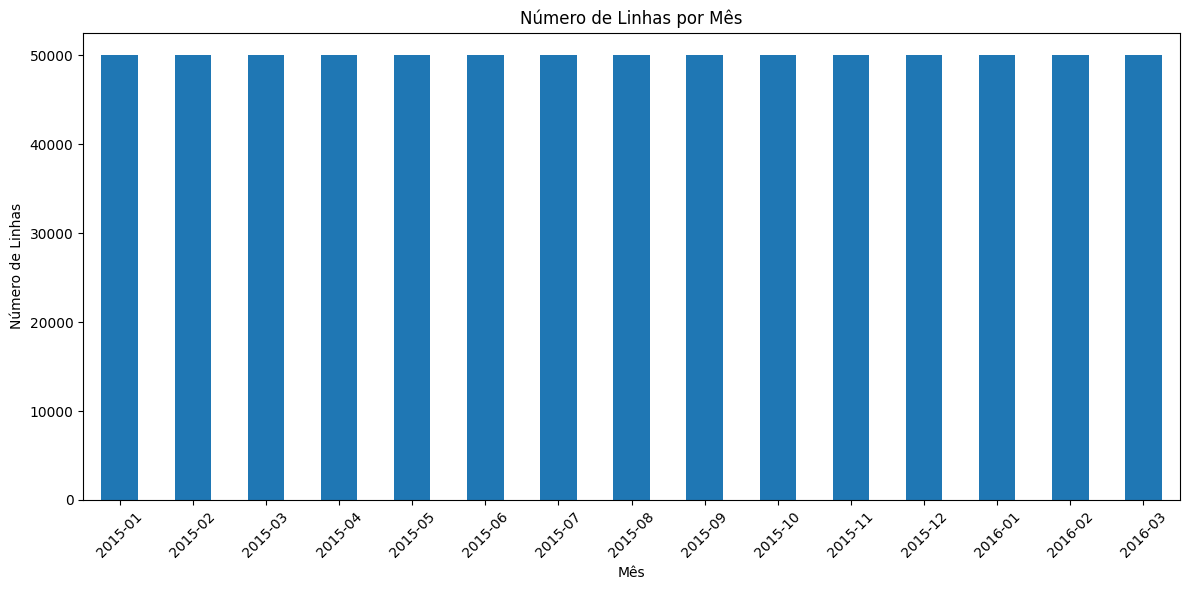

In [ ]:
# Plotar número de linhas por mês
plt.figure(figsize=(12, 6))
linhas_por_mes.plot(kind='bar')
plt.title('Número de Linhas por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Linhas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Identificar variáveis qualitativas e quantitativas
variaveis_qualitativas = df.select_dtypes(include=['object', 'category']).columns
variaveis_quantitativas = df.select_dtypes(include=['int64', 'float64']).columns
variaveis_quantitativas = [col for col in variaveis_quantitativas if col not in ['index', 'renda']]


Análise univariada para variáveis qualitativas:

sexo:
sexo
F    0.672773
M    0.327227
Name: proportion, dtype: float64
Número de categorias únicas: 2
Percentual de valores missing: 0.00%


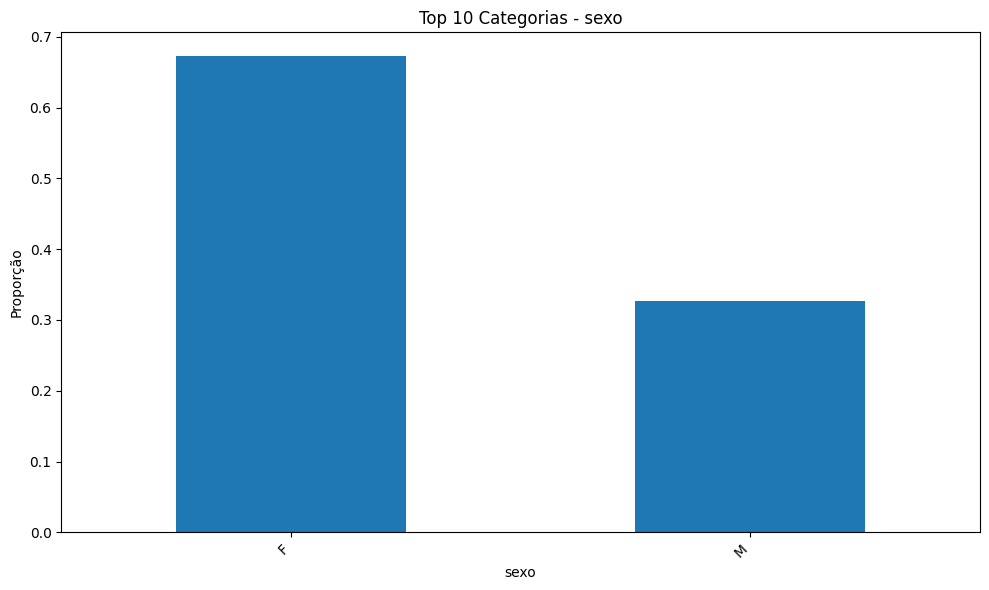


posse_de_veiculo:
posse_de_veiculo
N    0.610605
S    0.389395
Name: proportion, dtype: float64
Número de categorias únicas: 2
Percentual de valores missing: 0.00%


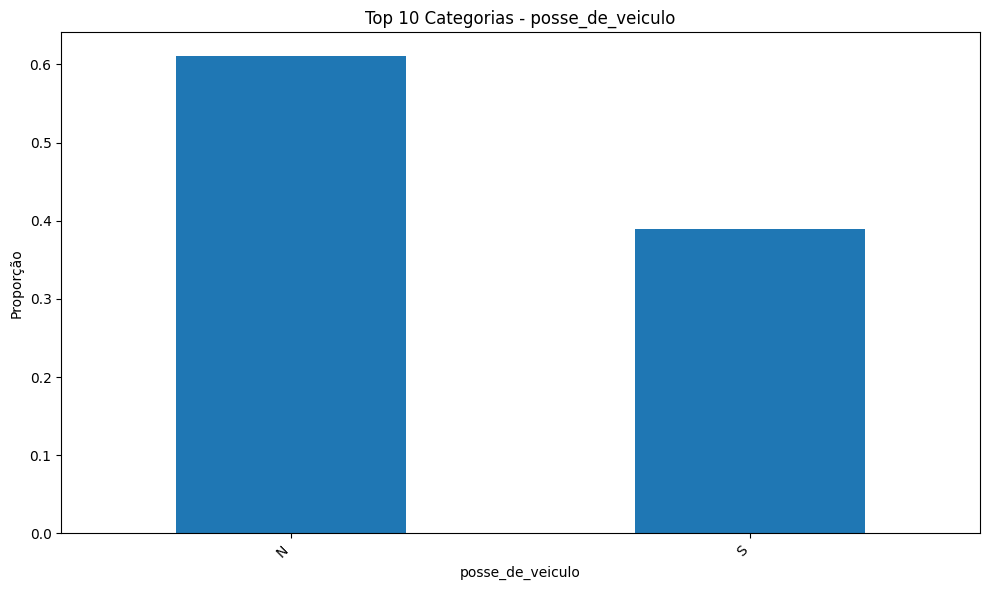


posse_de_imovel:
posse_de_imovel
S    0.671589
N    0.328411
Name: proportion, dtype: float64
Número de categorias únicas: 2
Percentual de valores missing: 0.00%


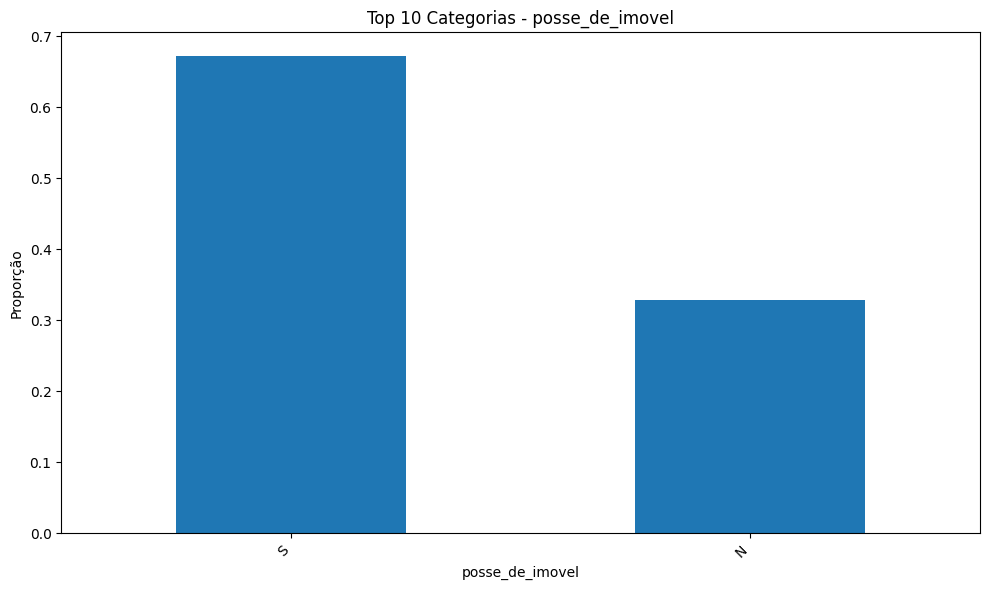


tipo_renda:
tipo_renda
Assalariado         0.514320
Empresário          0.230283
Pensionista         0.168353
Servidor público    0.086563
Bolsista            0.000481
Name: proportion, dtype: float64
Número de categorias únicas: 5
Percentual de valores missing: 0.00%


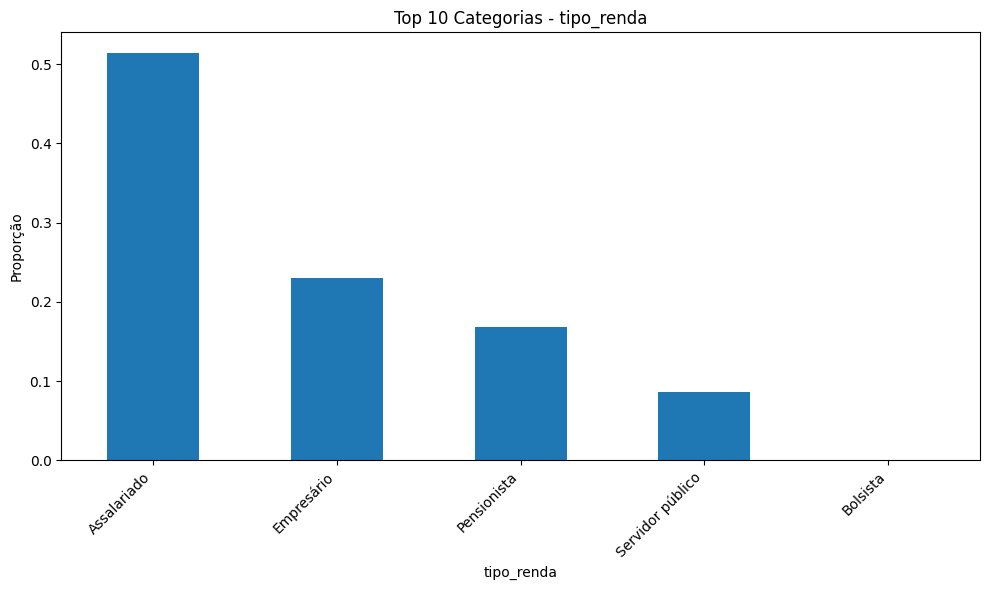


educacao:
educacao
Médio                  0.675781
Superior completo      0.272408
Superior incompleto    0.039295
Fundamental            0.011433
Pós graduação          0.001083
Name: proportion, dtype: float64
Número de categorias únicas: 5
Percentual de valores missing: 0.00%


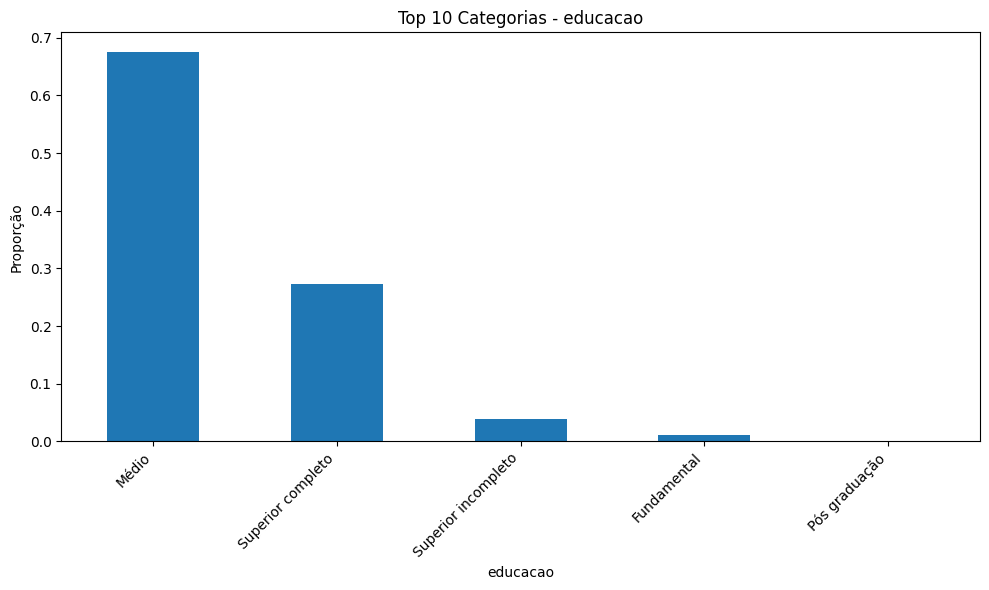


estado_civil:
estado_civil
Casado      0.701963
Solteiro    0.122212
União       0.076913
Separado    0.056761
Viúvo       0.042151
Name: proportion, dtype: float64
Número de categorias únicas: 5
Percentual de valores missing: 0.00%


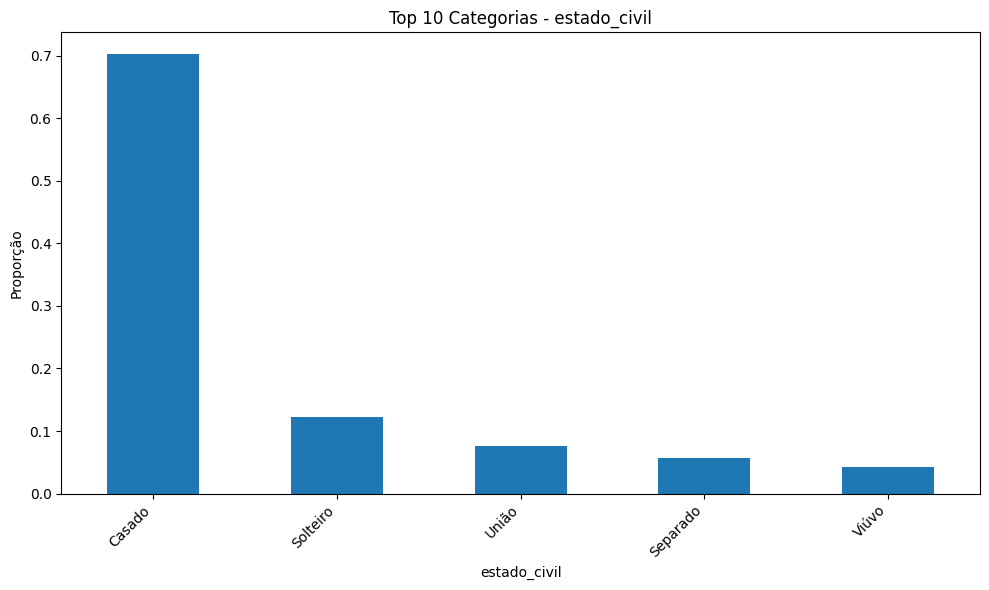


tipo_residencia:
tipo_residencia
Casa             0.899059
Com os pais      0.044309
Governamental    0.031253
Aluguel          0.013799
Estúdio          0.007193
Name: proportion, dtype: float64
Número de categorias únicas: 6
Percentual de valores missing: 0.00%


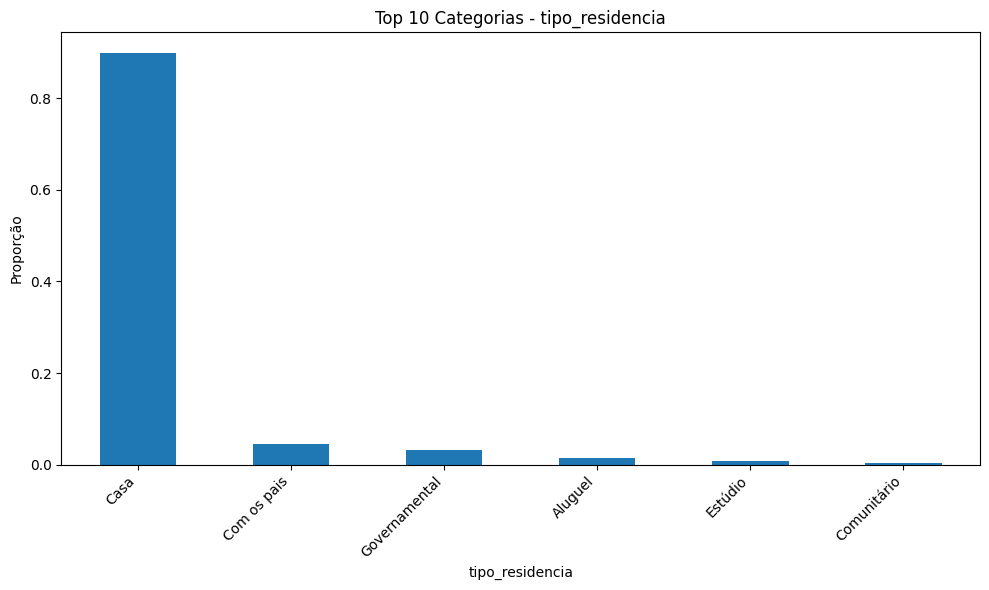

In [ ]:
# Análise univariada para variáveis qualitativas
print("\nAnálise univariada para variáveis qualitativas:")
for col in variaveis_qualitativas:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True).head())
    print(f"Número de categorias únicas: {df[col].nunique()}")
    print(f"Percentual de valores missing: {df[col].isnull().mean()*100:.2f}%")

    # Plotar gráfico de barras para as 10 categorias mais frequentes
    plt.figure(figsize=(10, 6))
    df[col].value_counts(normalize=True).head(10).plot(kind='bar')
    plt.title(f'Top 10 Categorias - {col}')
    plt.ylabel('Proporção')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



Análise univariada para variáveis quantitativas:

qtd_filhos:
count    750000.000000
mean          0.433251
std           0.739379
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 68.98%


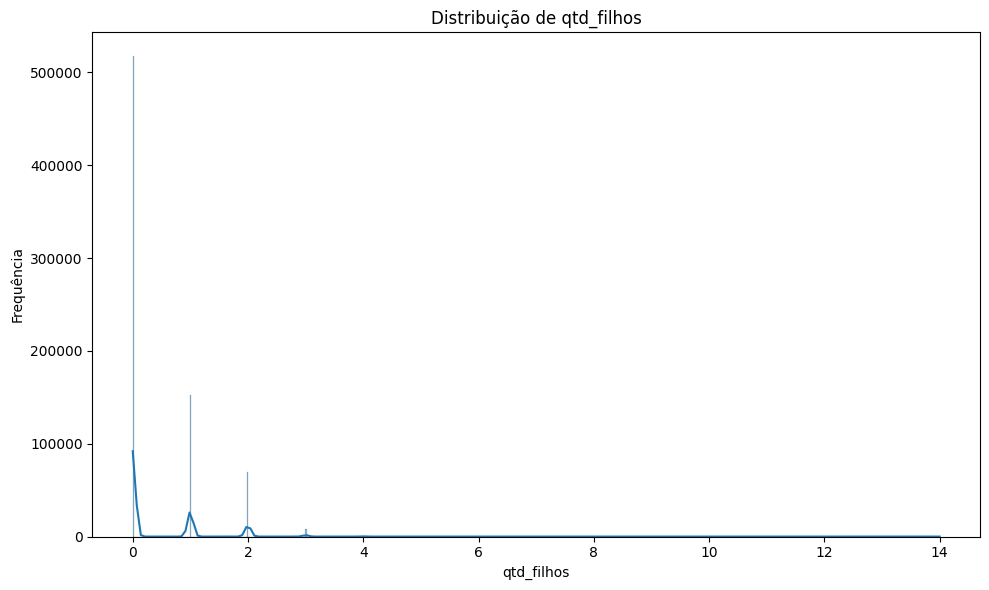


idade:
count    750000.000000
mean          0.474016
std           0.244128
min           0.000000
25%           0.260870
50%           0.456522
75%           0.673913
max           1.000000
Name: idade, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 0.07%


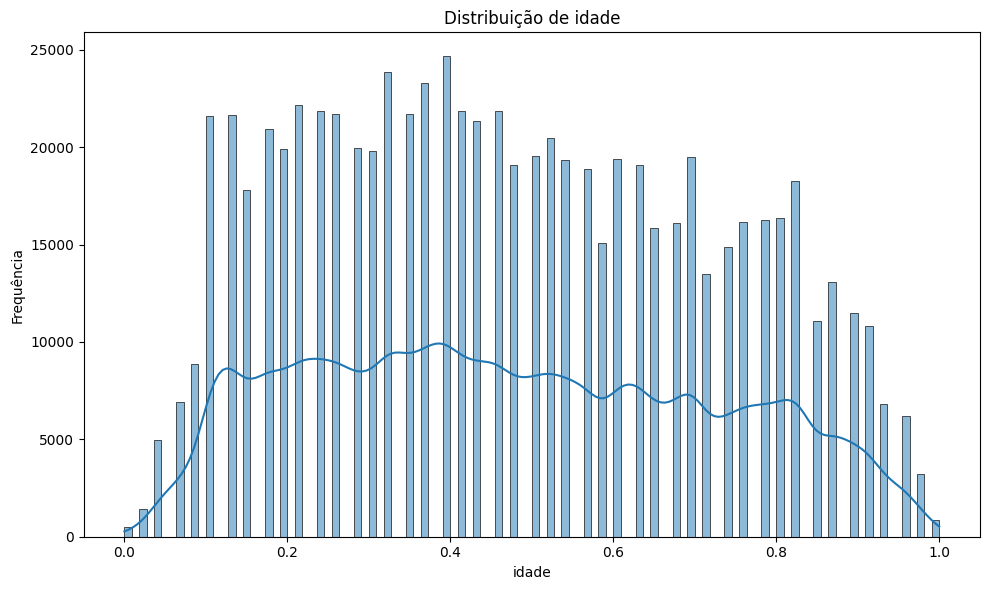


tempo_emprego:
count    750000.000000
mean          6.447258
std           6.752868
min           0.000000
25%           1.183562
50%           4.690411
75%           9.090411
max          42.906849
Name: tempo_emprego, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 16.79%


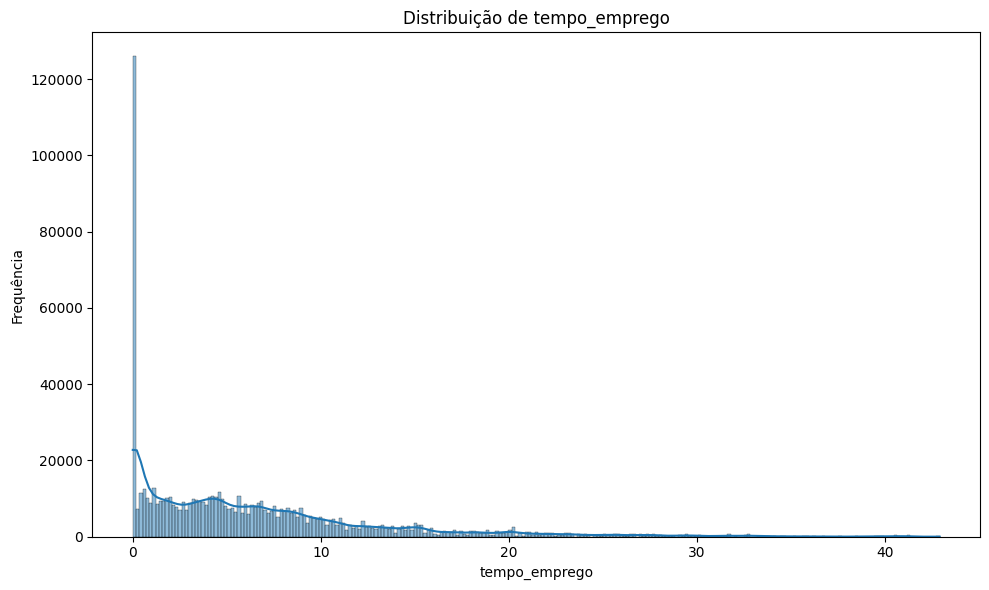


qt_pessoas_residencia:
count    750000.000000
mean          2.212241
std           0.903428
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: qt_pessoas_residencia, dtype: float64
Percentual de valores missing: 0.00%
Percentual de zeros: 0.00%


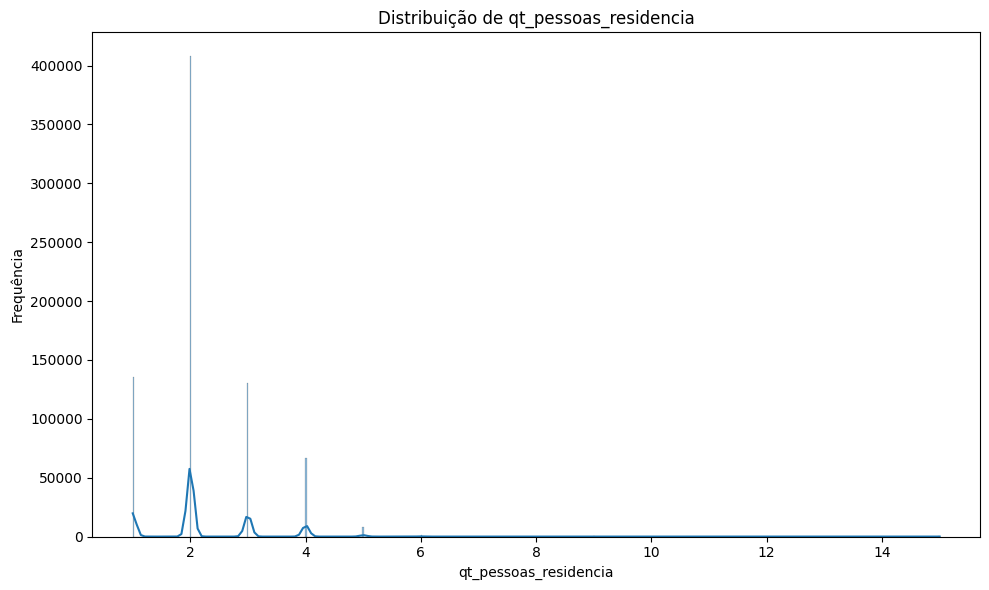

In [ ]:
# Análise univariada para variáveis quantitativas
print("\nAnálise univariada para variáveis quantitativas:")
for col in variaveis_quantitativas:
    print(f"\n{col}:")
    print(df[col].describe())
    print(f"Percentual de valores missing: {df[col].isnull().mean()*100:.2f}%")
    print(f"Percentual de zeros: {(df[col] == 0).mean()*100:.2f}%")

    # Plotar histograma
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()


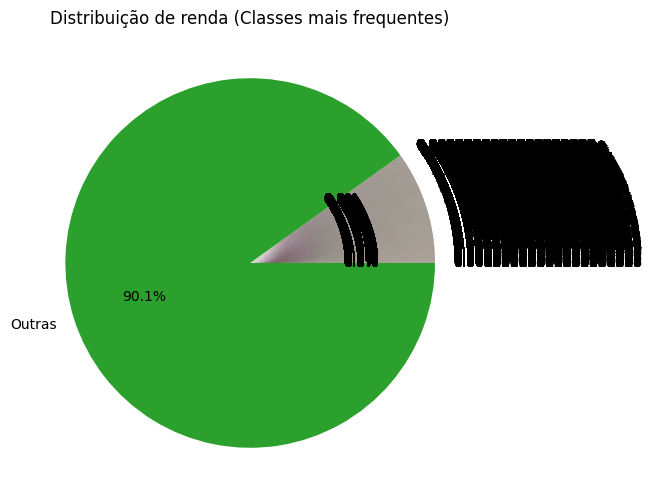

In [ ]:
# Agrupar classes menos frequentes
counts = df['renda'].value_counts()
top_counts = counts[counts > 10]  # Exibir apenas classes com mais de 10 ocorrências
others_count = counts[counts <= 10].sum()  # Somar classes com 10 ou menos ocorrências
top_counts['Outras'] = others_count

plt.figure(figsize=(8, 6))
top_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de renda (Classes mais frequentes)')
plt.ylabel('')
plt.show()

In [ ]:
# Agrupar classes menos frequentes para variáveis qualitativas
for col in variaveis_qualitativas:
    counts = df[col].value_counts()
    top_counts = counts[counts > 10]  # Exibir apenas classes com mais de 10 ocorrências
    others_count = counts[counts <= 10].sum()  # Somar classes com 10 ou menos ocorrências

    # Criar um novo DataFrame com as classes agrupadas
    df_grouped = df.copy()  # Criar uma cópia do DataFrame original
    df_grouped[col] = df_grouped[col].where(df_grouped[col].isin(top_counts.index), 'Outras')  # Agrupar as classes menos frequentes em 'Outras'

    # Substituir o DataFrame original pelo DataFrame agrupado
    df = df_grouped

In [ ]:
# Função para calcular IV (Information Value)
def calculate_iv(df, feature, target):

    df_woe = pd.DataFrame({'feature_value': df[feature].unique()})

    good_counts = df[df[target] == 0][feature].value_counts()
    bad_counts = df[df[target] == 1][feature].value_counts()

    df_woe['good'] = df_woe['feature_value'].map(good_counts).fillna(0.5)
    df_woe['bad'] = df_woe['feature_value'].map(bad_counts).fillna(0.5)

    df_woe['good_rate'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['bad_rate'] = df_woe['bad'] / df_woe['bad'].sum()
    df_woe['woe'] = np.log(df_woe['good_rate'] / df_woe['bad_rate'])
    df_woe['iv'] = (df_woe['good_rate'] - df_woe['bad_rate']) * df_woe['woe']
    return df_woe['iv'].sum()

In [ ]:
start_time = time.time()

# Amostra de 10% do DataFrame
sample_df = df.sample(frac=0.1, random_state=42)

# Análise bivariada para variáveis qualitativas
print("Análise bivariada para variáveis qualitativas:")
for col in variaveis_qualitativas:
    print(f"\n{col}:")

    # Tabela de contingência normalizada
    cont_table = pd.crosstab(sample_df[col], sample_df['renda'], normalize='index')
    print(cont_table)

    # Teste qui-quadrado
    chi2, p_value = stats.chi2_contingency(pd.crosstab(sample_df[col], sample_df['renda']))[:2]
    print(f"Qui-quadrado: {chi2:.4f}, p-value: {p_value:.4f}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time:.2f} segundos")

Análise bivariada para variáveis qualitativas:

sexo:
renda  3.770925e-07  4.743040e-06  5.840037e-06  1.326925e-05  1.560526e-05  \
sexo                                                                          
F           0.00002       0.00004       0.00002      0.000059       0.00002   
M           0.00000       0.00000       0.00000      0.000000       0.00000   

renda  1.614152e-05  1.688836e-05  1.830858e-05  2.113187e-05  2.136694e-05  \
sexo                                                                          
F           0.00004       0.00002       0.00002       0.00002       0.00002   
M           0.00000       0.00000       0.00000       0.00000       0.00000   

renda  ...  6.546839e-01  6.691871e-01  6.695564e-01  6.817253e-01  \
sexo   ...                                                           
F      ...       0.00002       0.00002       0.00002       0.00004   
M      ...       0.00000       0.00000       0.00000       0.00000   

renda  7.062565e-01  7.333930e-

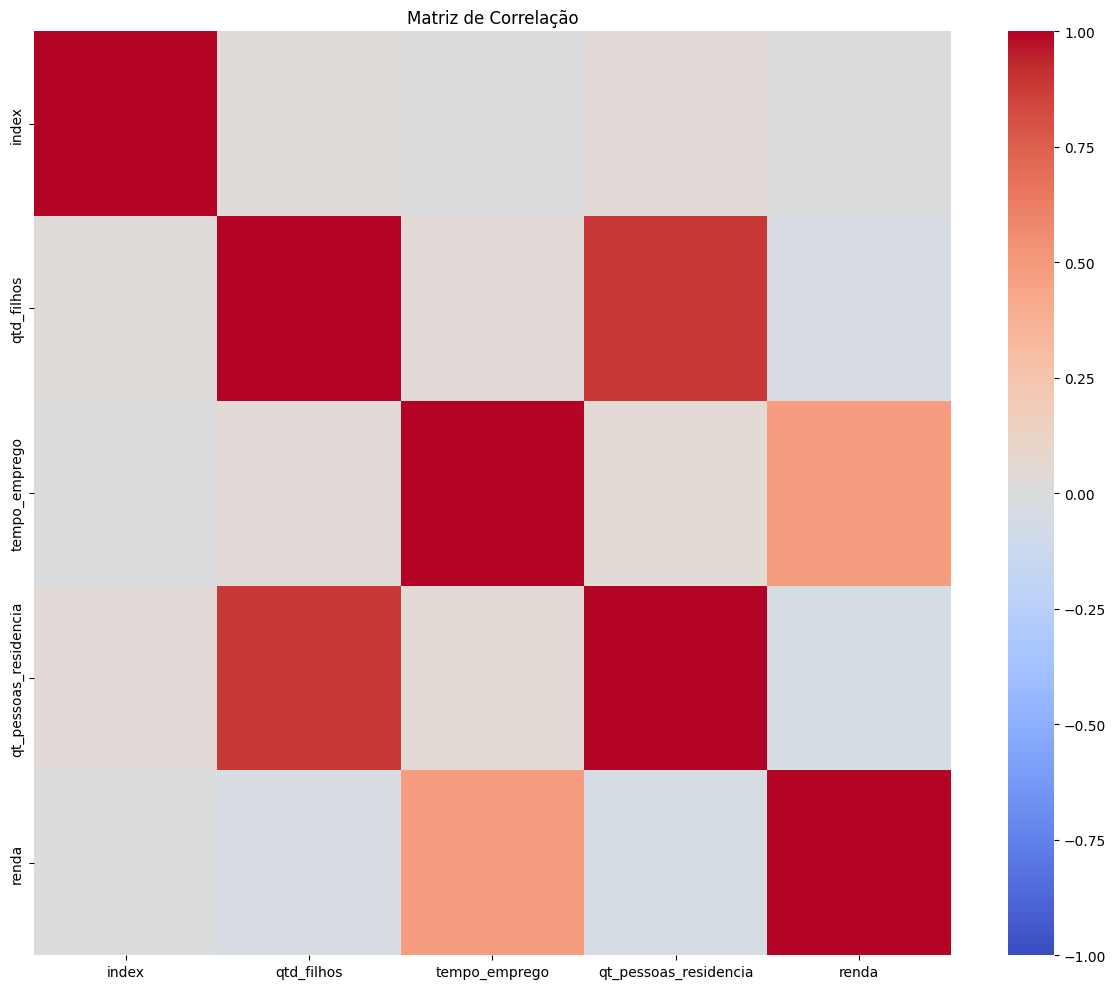

Tempo de execução: 0.60 segundos


In [ ]:
start_time = time.time()

# Selecionar apenas variáveis quantitativas e a variável alvo
sub_df = df[variaveis_quantitativas + ['renda']]

# Matriz de correlação
corr_matrix = sub_df.corr()

# Gerar o gráfico de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, annot=False)  # Desativar anotações
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time:.2f} segundos")

# **4. Modelagem**

## - Teste em diferentes algoritmos, como regressão logística, Random Forest e Decision Trees, além de aplicar validação e métricas para avaliar a performance dos modelos (KS, Gini, AUC, etc.).

In [ ]:
# Separar os três últimos meses como OOT
ultimos_3_meses = df['data_ref'].sort_values().unique()[-3:]
df_dev = df[~df['data_ref'].isin(ultimos_3_meses)]
df_oot = df[df['data_ref'].isin(ultimos_3_meses)]

In [ ]:
# Remover variáveis não explicativas
colunas_para_remover = ['data_ref', 'idade']

# Verificar se as colunas existem antes de removê-las
colunas_existentes = df_dev.columns

colunas_para_remover = [coluna for coluna in colunas_para_remover if coluna in colunas_existentes]

# Remover as colunas existentes
df_dev = df_dev.drop(columns=colunas_para_remover)
df_oot = df_oot.drop(columns=colunas_para_remover)

In [ ]:
# Função para tratar outliers
def tratar_outliers(serie):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    return serie.clip(limite_inferior, limite_superior)

In [ ]:
# Função para agrupar categorias raras
def agrupar_categorias_raras(serie, threshold=0.05):
    contagem = serie.value_counts(normalize=True)
    categorias_raras = contagem[contagem < threshold].index
    return serie.replace(categorias_raras, 'Outros')

In [ ]:
# Tratamento de valores missing, outliers e zeros estruturais
for col in df_dev.columns:
    if df_dev[col].dtype in ['int64', 'float64'] and col != 'renda':
        # Tratar zeros estruturais
        if (df_dev[col] == 0).sum() / len(df_dev) > 0.1:  # Se mais de 10% são zeros
            df_dev[f'{col}_zero'] = (df_dev[col] == 0).astype(int)
            df_dev.loc[df_dev[col] == 0, col] = np.nan

        # Imputar valores missing com mediana
        df_dev[col] = df_dev[col].fillna(df_dev[col].median())

        # Tratar outliers
        df_dev[col] = tratar_outliers(df_dev[col])
    elif df_dev[col].dtype == 'object':
        # Agrupar categorias raras
        df_dev[col] = agrupar_categorias_raras(df_dev[col])

        # Tratar valores missing em variáveis categóricas
        df_dev[col] = df_dev[col].fillna('Desconhecido')


In [ ]:
# Separar features e target
X = df_dev.drop('renda', axis=1)
y = df_dev['renda']

# Codificação one-hot para variáveis ​​categóricas
X = pd.get_dummies(X, drop_first=True)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar o modelo de REGRESSÃO LINEAR
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Gerar previsões no conjunto de testes
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared no conjunto de teste: {r2:.4f}")
print(f"Mean Squared Error no conjunto de teste: {mse:.4f}")

R-squared no conjunto de teste: 0.1469
Mean Squared Error no conjunto de teste: 0.0004


In [ ]:
# Avaliar no conjunto OOT
X_oot = df_oot.drop('renda', axis=1)
X_oot = pd.get_dummies(X_oot, drop_first=True)

# Garanta colunas de variáveis ​​​​fictícias consistentes
X_oot = X_oot.reindex(columns=X.columns, fill_value=0)

# Imputar valores ausentes, se houver algum, após a ocorrência one-hot
imputer = SimpleImputer(strategy='most_frequent')
X_oot_imputed = imputer.fit_transform(X_oot)

# Dimensione os dados imputados
X_oot_scaled = scaler.transform(X_oot_imputed)
y_oot = df_oot['renda']

# Como LinearRegression é usado, preveja diretamente em vez de predizer_proba
y_oot_pred = model.predict(X_oot_scaled)

# Para problemas de regressão, métricas como R-quadrado e MSE são mais apropriadas
r2_oot = r2_score(y_oot, y_oot_pred)
mse_oot = mean_squared_error(y_oot, y_oot_pred)

print(f"\nR-squared no conjunto OOT: {r2_oot:.4f}")
print(f"Mean Squared Error no conjunto OOT: {mse_oot:.4f}")


R-squared no conjunto OOT: -3.6334
Mean Squared Error no conjunto OOT: 0.0001


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


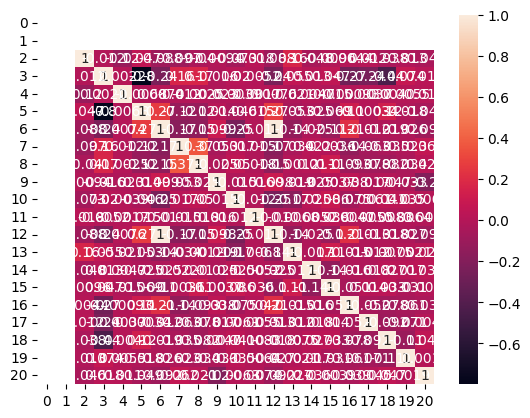

Column '0' is constant.
Column '1' is constant.
             0         1             2             3             4   \
count  480000.0  480000.0  4.800000e+05  4.800000e+05  4.800000e+05   
mean        1.0       0.0 -5.687747e-16 -1.546615e-16  8.274862e-18   
std         0.0       0.0  1.000001e+00  1.000001e+00  1.000001e+00   
min         1.0       0.0 -1.465132e+00 -1.388979e+00 -2.541075e-01   
25%         1.0       0.0 -7.117675e-01 -2.337107e-01 -2.541075e-01   
50%         1.0       0.0 -1.954432e-01 -2.337107e-01 -2.541075e-01   
75%         1.0       0.0  4.511356e-01  9.215574e-01 -2.541075e-01   
max         1.0       0.0  2.197690e+00  2.654460e+00  3.935342e+00   

                 5             6             7             8             9   \
count  4.800000e+05  4.800000e+05  4.800000e+05  4.800000e+05  4.800000e+05   
mean   5.655846e-17  2.448412e-17  4.439412e-17  1.163514e-17  9.353999e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00

In [ ]:
# Adicionar uma constante ao X_train_scaled para o intercepto
X_train_sm = sm.add_constant(X_train_scaled)

# Convert X_train_sm to a Pandas DataFrame
X_train_sm = pd.DataFrame(X_train_sm)

# Calcule a matriz de correlação
corr_matrix = X_train_sm.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Check for constant columns
for col in X_train_sm.columns:
  if X_train_sm[col].nunique() == 1:
    print(f"Column '{col}' is constant.")

# Verifique a separação perfeita
print(X_train_sm.describe())

# Converta y_train em uma série Pandas, se ainda não estiver
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train)

print(y_train.value_counts())

In [ ]:
# Criar equação preditiva
coef_dict = dict(zip(X.columns, model.coef_)) # remove the [0] here
intercept = model.intercept_ # remove the [0] here

print("\nEquação Preditiva para 'inadimplente':")
equation = f"log(odds) = {intercept:.4f}"
for feature, coef in coef_dict.items():
    if abs(coef) > 0.001:  # Mostrar apenas coeficientes significativos
        equation += f" + ({coef:.4f} * {feature})"
print(equation)


Equação Preditiva para 'inadimplente':
log(odds) = 0.0066 + (0.0077 * tempo_emprego) + (-0.0020 * tipo_renda_Pensionista)


In [ ]:
# Remover variáveis não explicativas
colunas_para_remover = ['data_ref', 'idade']

# Verifique se as colunas existem antes de descartar
for col in colunas_para_remover:
    if col in df_dev.columns:
        df_dev = df_dev.drop(columns=[col])
    else:
        print(f"Column '{col}' not found in df_dev")
    if col in df_oot.columns:
        df_oot = df_oot.drop(columns=[col])
    else:
        print(f"Column '{col}' not found in df_oot")

Column 'data_ref' not found in df_dev
Column 'data_ref' not found in df_oot
Column 'idade' not found in df_dev
Column 'idade' not found in df_oot


In [ ]:
# Separar features e target
X_dev = df_dev.drop('renda', axis=1)
y_dev = df_dev['renda']
X_oot = df_oot.drop('renda', axis=1)
y_oot = df_oot['renda']

In [ ]:
# One-hot encoding para variáveis categóricas
X_dev = pd.get_dummies(X_dev, drop_first=True)
X_oot = pd.get_dummies(X_oot, drop_first=True)

In [ ]:
# Alinhar colunas entre desenvolvimento e OOT
X_oot = X_oot.reindex(columns=X_dev.columns, fill_value=0)

In [ ]:
# Dividir dados de desenvolvimento em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)

In [ ]:
# Escalar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_oot_scaled = scaler.transform(X_oot)

In [ ]:
# Crie um impuador para substituir os valores ausentes pela média
imputer = SimpleImputer(strategy='mean')

# Ajuste o imputer nos dados de treinamento e transforme os dados de treinamento e de teste
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_oot_imputed = imputer.transform(X_oot)

# Agora você pode dimensionar os dados imputados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
X_oot_scaled = scaler.transform(X_oot_imputed)

# Treine o modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# Funções para cálculo de métricas

def calcular_ks(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    return max(tpr - fpr)

def calcular_gini(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

def avaliar_modelo(y_true, y_pred_proba, nome_conjunto):
    y_pred = (y_pred_proba > 0.5).astype(int)

    acuracia = accuracy_score(y_true, y_pred)
    ks = calcular_ks(y_true, y_pred_proba)
    gini = calcular_gini(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    print(f"\nMétricas para o conjunto {nome_conjunto}:")
    print(f"Acurácia: {acuracia:.4f}")
    print(f"KS: {ks:.4f}")
    print(f"Gini: {gini:.4f}")
    print(f"AUC: {auc:.4f}")

    # Added return statement to return the calculated metrics
    return acuracia, ks, gini, auc

In [ ]:
# Treine o modelo
model = LogisticRegression()

# Talvez seja necessário ajustar o limite com base nos seus dados
y_train_discrete = (y_train > y_train.mean()).astype(int)
model.fit(X_train_scaled, y_train_discrete)

# Avaliação na base de desenvolvimento (conjunto de teste)
y_pred_proba_dev = model.predict_proba(X_test_scaled)[:, 1]

# Converta y_test em valores discretos com o mesmo limite
y_test_discrete = (y_test > y_train.mean()).astype(int)
metricas_dev = avaliar_modelo(y_test_discrete, y_pred_proba_dev, "de Desenvolvimento (Teste)")


Métricas para o conjunto de Desenvolvimento (Teste):
Acurácia: 0.8653
KS: 0.5401
Gini: 0.6945
AUC: 0.8473


In [ ]:
# Avaliação na base out of time (OOT)
y_pred_proba_oot = model.predict_proba(X_oot_scaled)[:, 1]

# Converta y_oot em valores discretos usando o mesmo limite dos dados de treinamento e teste
y_oot_discrete = (y_oot > y_train.mean()).astype(int)

metricas_oot = avaliar_modelo(y_oot_discrete, y_pred_proba_oot, "Out of Time (OOT)")


Métricas para o conjunto Out of Time (OOT):
Acurácia: 0.9080
KS: 0.8595
Gini: 0.9547
AUC: 0.9773


In [ ]:
# Comparação das métricas
print("\nComparação das métricas:")
metricas = ['Acurácia', 'KS', 'Gini', 'AUC']
for i, metrica in enumerate(metricas):
    print(f"{metrica:<10} - Desenvolvimento: {metricas_dev[i]:.4f}, OOT: {metricas_oot[i]:.4f}, Diferença: {metricas_oot[i]-metricas_dev[i]:.4f}")


Comparação das métricas:
Acurácia   - Desenvolvimento: 0.8653, OOT: 0.9080, Diferença: 0.0427
KS         - Desenvolvimento: 0.5401, OOT: 0.8595, Diferença: 0.3194
Gini       - Desenvolvimento: 0.6945, OOT: 0.9547, Diferença: 0.2601
AUC        - Desenvolvimento: 0.8473, OOT: 0.9773, Diferença: 0.1301


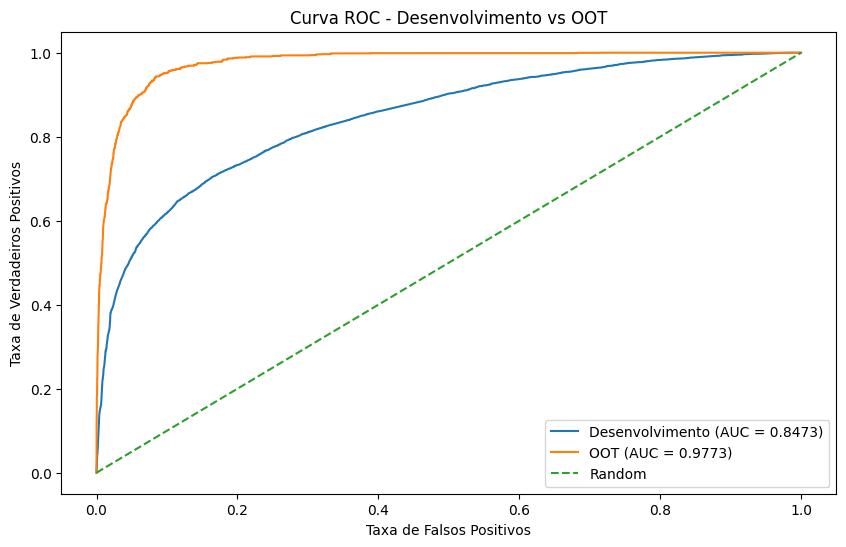

In [ ]:
plt.figure(figsize=(10, 6))

# Use as versões discretizadas de y_test e y_oot
fpr_dev, tpr_dev, _ = roc_curve(y_test_discrete, y_pred_proba_dev)
fpr_oot, tpr_oot, _ = roc_curve(y_oot_discrete, y_pred_proba_oot)

plt.plot(fpr_dev, tpr_dev, label=f'Desenvolvimento (AUC = {roc_auc_score(y_test_discrete, y_pred_proba_dev):.4f})')
plt.plot(fpr_oot, tpr_oot, label=f'OOT (AUC = {roc_auc_score(y_oot_discrete, y_pred_proba_oot):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Desenvolvimento vs OOT')
plt.legend()
plt.show()

In [ ]:
# Remover variáveis não explicativas
colunas_para_remover = ['data_ref', 'idade']

# Verificar se as colunas existem antes de removê-las
for coluna in colunas_para_remover:
  if coluna in df_dev.columns:
    df_dev = df_dev.drop(columns=coluna)
  if coluna in df_oot.columns:
    df_oot = df_oot.drop(columns=coluna)

In [ ]:
# Separar features e target
X_dev = df_dev.drop('renda', axis=1)
y_dev = df_dev['renda']
X_oot = df_oot.drop('renda', axis=1)
y_oot = df_oot['renda']


In [ ]:
# Identificar colunas numéricas e categóricas
colunas_numericas = X_dev.select_dtypes(include=['int64', 'float64']).columns
colunas_categoricas = X_dev.select_dtypes(include=['object', 'category']).columns

In [ ]:
# Criar preprocessadores para colunas numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Use sparse_output instead of sparse
])

In [ ]:
# Combinar preprocessadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, colunas_numericas),
        ('cat', categorical_transformer, colunas_categoricas)
    ])


In [ ]:
# Criar o pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

In [ ]:
# Dividir dados de desenvolvimento em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)

In [ ]:
   # Criar o pipeline completo
   pipeline = Pipeline(steps=[
       ('preprocessor', preprocessor),
       ('regressor', LinearRegression())
   ])

In [ ]:
   # Criar o pipeline completo
   pipeline = Pipeline(steps=[
       ('preprocessor', preprocessor),
       ('regressor', DecisionTreeRegressor(random_state=42))
   ])

In [ ]:
   # Criar o pipeline completo
   pipeline = Pipeline(steps=[
       ('preprocessor', preprocessor),
       ('regressor', RandomForestRegressor(random_state=42))
   ])

In [ ]:
# Treinar o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia',
       'qtd_filhos_zero', 'tempo_emprego_zero'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [ ]:
# Remover variáveis não explicativas
colunas_para_remover = ['data_ref', 'idade']

# Verificar se as colunas existem antes de removê-las
for coluna in colunas_para_remover:
  if coluna in df_dev.columns:
    df_dev = df_dev.drop(columns=coluna)
  if coluna in df_oot.columns:
    df_oot = df_oot.drop(columns=coluna)

In [ ]:
# Analisar valores nulos
nulos = df.isnull().sum()
percentual_nulos = (nulos / len(df)) * 100

In [ ]:
# Identificar tipos de dados
tipos = df.dtypes

In [ ]:
# Calcular estatísticas para colunas numéricas
estatisticas_numericas = df.select_dtypes(include=['int64', 'float64']).agg(['mean', 'median'])
# Calcular a moda separadamente
moda = df.select_dtypes(include=['int64', 'float64']).mode()

In [ ]:
# Substituir NaN por 0 no DataFrame
df.fillna(0, inplace=True)

In [ ]:
# Combinar informações
analise = pd.DataFrame({
    'Tipo': tipos,
    'Nulos': nulos,
    'Percentual Nulos': percentual_nulos,
    'Média': estatisticas_numericas.loc['mean'],
    'Mediana': estatisticas_numericas.loc['median'],
    'Moda': moda.iloc[0]
})

print(analise)

                                 Tipo  Nulos  Percentual Nulos        Média  \
data_ref               datetime64[ns]      0               0.0          NaN   
educacao                       object      0               0.0          NaN   
estado_civil                   object      0               0.0          NaN   
idade                         float64      0               0.0     0.474016   
index                           int64      0               0.0  8319.272793   
mau                              bool      0               0.0          NaN   
posse_de_imovel                object      0               0.0          NaN   
posse_de_veiculo               object      0               0.0          NaN   
qt_pessoas_residencia         float64      0               0.0     2.212241   
qtd_filhos                      int64      0               0.0     0.433251   
renda                         float64      0               0.0     0.005664   
sexo                           object      0        

In [ ]:
def identificar_outliers(df, coluna):
    # Método IQR
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior_iqr = Q1 - 1.5 * IQR
    limite_superior_iqr = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[coluna] < limite_inferior_iqr) | (df[coluna] > limite_superior_iqr)]

    # Método Z-score
    z_scores = np.abs(stats.zscore(df[coluna]))
    outliers_zscore = df[z_scores > 3]

    # Método do desvio padrão
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    limite_inferior_std = media - 3 * desvio_padrao
    limite_superior_std = media + 3 * desvio_padrao
    outliers_std = df[(df[coluna] < limite_inferior_std) | (df[coluna] > limite_superior_std)]

    return {
        'IQR': outliers_iqr,
        'Z-score': outliers_zscore,
        'Desvio Padrão': outliers_std
    }

In [ ]:
# Identificar colunas numéricas
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# Analisar outliers para cada coluna numérica
for coluna in colunas_numericas:
    outliers = identificar_outliers(df, coluna)
    print(f"\nOutliers na coluna {coluna}:")
    for metodo, outliers_df in outliers.items():
        print(f"  {metodo}: {len(outliers_df)} outliers identificados")


Outliers na coluna index:
  IQR: 0 outliers identificados
  Z-score: 0 outliers identificados
  Desvio Padrão: 0 outliers identificados

Outliers na coluna qtd_filhos:
  IQR: 10016 outliers identificados
  Z-score: 10016 outliers identificados
  Desvio Padrão: 10016 outliers identificados

Outliers na coluna idade:
  IQR: 0 outliers identificados
  Z-score: 0 outliers identificados
  Desvio Padrão: 0 outliers identificados

Outliers na coluna tempo_emprego:
  IQR: 33795 outliers identificados
  Z-score: 14947 outliers identificados
  Desvio Padrão: 14947 outliers identificados

Outliers na coluna qt_pessoas_residencia:
  IQR: 9629 outliers identificados
  Z-score: 9629 outliers identificados
  Desvio Padrão: 9629 outliers identificados

Outliers na coluna renda:
  IQR: 79072 outliers identificados
  Z-score: 8583 outliers identificados
  Desvio Padrão: 8583 outliers identificados


In [ ]:
# Separar features e target
X = df.drop('renda', axis=1)
y = df['renda']

In [ ]:
# Identificar colunas numéricas e categóricas
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
colunas_categoricas = X.select_dtypes(include=['object', 'category']).columns

In [ ]:
# Criar preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colunas_categoricas)
    ])

In [ ]:
# Criar preprocessador com SimpleImputer para tratar valores ausentes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), colunas_numericas),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            # Updated to use sparse_output instead of sparse, ensuring compatibility.
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), colunas_categoricas)
    ])

In [ ]:
# Criar pipeline com Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [ ]:
# Ajustar o pipeline
rf_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['index', 'qtd_filhos', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object'))])),
                ('classifier', RandomForestRegressor(random_state=42))])

In [ ]:
# Obter nomes das features após one-hot encoding
feature_names = (colunas_numericas.tolist() +
                 rf_pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['encoder']
                 .get_feature_names_out(colunas_categoricas).tolist())

In [ ]:
# Feature Importance do Random Forest
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 features por importância:")
print(feature_importance.head(10))


Top 10 features por importância:
                      feature  importance
0               tempo_emprego    0.614609
1                       index    0.288064
2                       idade    0.022967
3                      sexo_M    0.015903
4                      sexo_F    0.011942
5          estado_civil_Viúvo    0.005121
6       qt_pessoas_residencia    0.004809
7  educacao_Superior completo    0.003640
8      tipo_renda_Assalariado    0.003359
9         estado_civil_Casado    0.003265


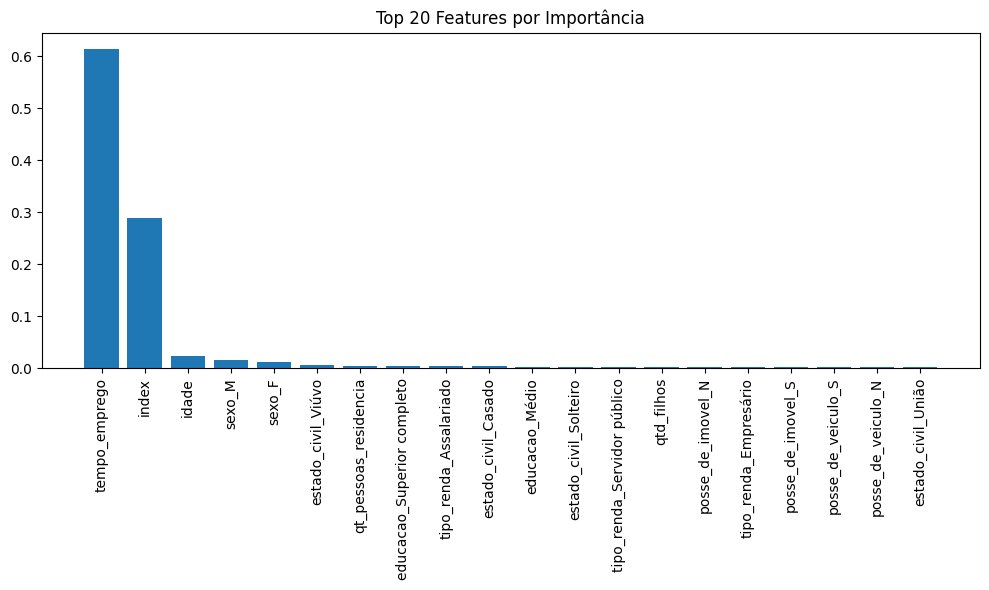

In [ ]:
# Plotar Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Features por Importância')
plt.tight_layout()
plt.show()

In [ ]:
# Identificar colunas numéricas e categóricas
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
colunas_categoricas = X.select_dtypes(include=['object', 'category']).columns

In [ ]:
# Criar preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), colunas_numericas),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Changed 'sparse' to 'sparse_output'
        ]), colunas_categoricas)
    ])


In [ ]:
# Criar pipeline com PCA
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5, random_state=42))
])

In [ ]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Ajustar o pipeline de PCA
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

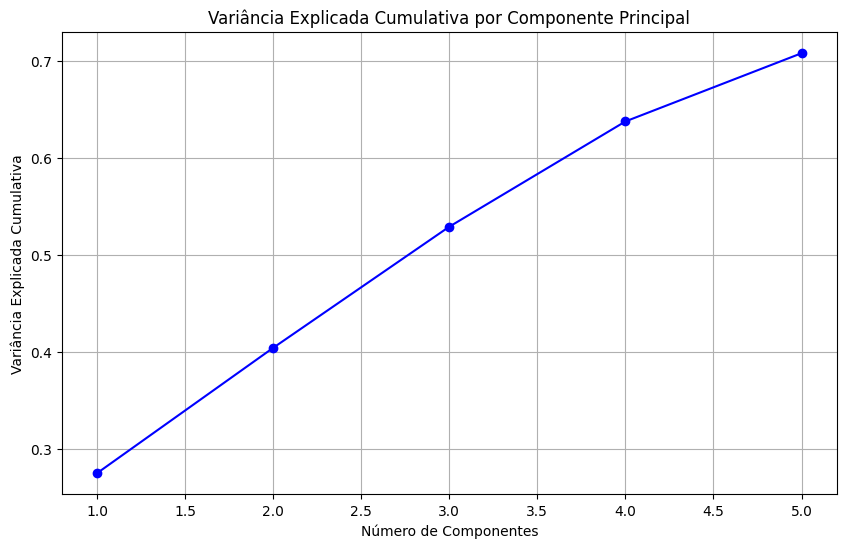

Variância explicada por cada componente:
PC1: 0.2752
PC2: 0.1291
PC3: 0.1247
PC4: 0.1084
PC5: 0.0702

Variância total explicada pelas 5 componentes: 0.7076


In [ ]:
# Visualizar a variância explicada
pca = pca_pipeline.named_steps['pca']
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cumulative_variance_ratio, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.title('Variância Explicada Cumulativa por Componente Principal')
plt.grid(True)
plt.show()

print("Variância explicada por cada componente:")
for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f"PC{i}: {ratio:.4f}")

print(f"\nVariância total explicada pelas 5 componentes: {sum(explained_variance_ratio):.4f}")

In [ ]:
# Lista de colunas categóricas para aplicar one-hot encoding
colunas_categoricas = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

In [ ]:
# Aplicar get_dummies() nas colunas categóricas
df_encoded = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

In [ ]:
# Verificar as novas colunas criadas
novas_colunas = [col for col in df_encoded.columns if col not in df.columns]
print("Novas colunas criadas:")
print(novas_colunas)

Novas colunas criadas:
['sexo_M', 'posse_de_veiculo_S', 'posse_de_imovel_S', 'tipo_renda_Bolsista', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'tipo_renda_Servidor público', 'educacao_Médio', 'educacao_Pós graduação', 'educacao_Superior completo', 'educacao_Superior incompleto', 'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Casa', 'tipo_residencia_Com os pais', 'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']


In [ ]:
# Mostrar as primeiras linhas do dataframe transformado
print("\nPrimeiras linhas do dataframe transformado:")
print(df_encoded.head())


Primeiras linhas do dataframe transformado:
    data_ref  index  qtd_filhos     idade  tempo_emprego  \
0 2015-01-01   5733           0  0.456522       6.873973   
1 2015-01-01    727           0  0.282609       4.526027   
2 2015-01-01   6374           2  0.195652       0.243836   
3 2015-01-01   9566           0  0.695652      12.772603   
4 2015-01-01   9502           0  0.195652       8.432877   

   qt_pessoas_residencia     renda    mau  sexo_M  posse_de_veiculo_S  ...  \
0                    1.0  0.000590  False   False               False  ...   
1                    2.0  0.000752  False   False                True  ...   
2                    4.0  0.000361  False   False               False  ...   
3                    2.0  0.003333  False   False               False  ...   
4                    1.0  0.000682  False   False                True  ...   

   educacao_Superior incompleto  estado_civil_Separado  estado_civil_Solteiro  \
0                         False             

In [ ]:
# Informações sobre o novo dataframe
print("\nInformações sobre o novo dataframe:")
print(df_encoded.info())


Informações sobre o novo dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   data_ref                       750000 non-null  datetime64[ns]
 1   index                          750000 non-null  int64         
 2   qtd_filhos                     750000 non-null  int64         
 3   idade                          750000 non-null  float64       
 4   tempo_emprego                  750000 non-null  float64       
 5   qt_pessoas_residencia          750000 non-null  float64       
 6   renda                          750000 non-null  float64       
 7   mau                            750000 non-null  bool          
 8   sexo_M                         750000 non-null  bool          
 9   posse_de_veiculo_S             750000 non-null  bool          
 10  posse_de_imovel_S              

In [ ]:
# Comparar o número de colunas antes e depois
print(f"\nNúmero de colunas antes: {df.shape[1]}")
print(f"Número de colunas depois: {df_encoded.shape[1]}")


Número de colunas antes: 15
Número de colunas depois: 28


In [ ]:
# Verificar se há valores nulos nas novas colunas
nulos_novas_colunas = df_encoded[novas_colunas].isnull().sum()
print("\nValores nulos nas novas colunas:")
print(nulos_novas_colunas)


Valores nulos nas novas colunas:
sexo_M                           0
posse_de_veiculo_S               0
posse_de_imovel_S                0
tipo_renda_Bolsista              0
tipo_renda_Empresário            0
tipo_renda_Pensionista           0
tipo_renda_Servidor público      0
educacao_Médio                   0
educacao_Pós graduação           0
educacao_Superior completo       0
educacao_Superior incompleto     0
estado_civil_Separado            0
estado_civil_Solteiro            0
estado_civil_União               0
estado_civil_Viúvo               0
tipo_residencia_Casa             0
tipo_residencia_Com os pais      0
tipo_residencia_Comunitário      0
tipo_residencia_Estúdio          0
tipo_residencia_Governamental    0
dtype: int64


In [ ]:
# Distribuição das novas variáveis binárias
print("\nDistribuição das novas variáveis binárias:")
for col in novas_colunas:
    print(f"{col}:")
    print(df_encoded[col].value_counts(normalize=True))
    print()


Distribuição das novas variáveis binárias:
sexo_M:
sexo_M
False    0.672773
True     0.327227
Name: proportion, dtype: float64

posse_de_veiculo_S:
posse_de_veiculo_S
False    0.610605
True     0.389395
Name: proportion, dtype: float64

posse_de_imovel_S:
posse_de_imovel_S
True     0.671589
False    0.328411
Name: proportion, dtype: float64

tipo_renda_Bolsista:
tipo_renda_Bolsista
False    0.999519
True     0.000481
Name: proportion, dtype: float64

tipo_renda_Empresário:
tipo_renda_Empresário
False    0.769717
True     0.230283
Name: proportion, dtype: float64

tipo_renda_Pensionista:
tipo_renda_Pensionista
False    0.831647
True     0.168353
Name: proportion, dtype: float64

tipo_renda_Servidor público:
tipo_renda_Servidor público
False    0.913437
True     0.086563
Name: proportion, dtype: float64

educacao_Médio:
educacao_Médio
True     0.675781
False    0.324219
Name: proportion, dtype: float64

educacao_Pós graduação:
educacao_Pós graduação
False    0.998917
True     0.001083
N

# **5. Avaliação**

## - O desempenho dos modelos em conjuntos de dados de desenvolvimento e out-of-time, comparando métricas para garantir a robustez do modelo.

# **6. Implementação**

## - Pode envolver o uso do modelo em produção para prever a renda em tempo real, talvez em um sistema de concessão de seguros.

## **Monitoramento e Manutenção**

## - Importante monitorar o desempenho do modelo ao longo do tempo, ajustando-o conforme necessário para garantir que ele continue a oferecer previsões precisas.

# ⏰ **Exploração e Arquitetura do CRISP-DM no Crédit Scoring**
## Este notebook faz parte do Projeto da Ebac Módulo 38.



# ⏰ **Dados:**
## Os dados representam informação sobre o score de cartão de crédito, contam com as seguintes colunas:
**- Data de referência**

**- Index**

**- Sexo**

**- Posse de veículo**

**- Posse de imóvel**

**- Quantidade de filhos**

**- Tipo de renda**

**- Educação**

**- Estado civil**

**- Tipo de residência**

**- Idade**

**- Tempo de emprego**

**- Quantidade de pessoas na residência**

**- Renda**

**- Mau**

# ⏰ **Exploração de Dados:**
## A primeira fase da análise é entender o que tem na materia prima.
## **Vamos explorar os dados:**

💢 **Qual a quantidade de informação temos na base de dados?**

**df = pd.read_csv**('credit_scoring.ftr')

✅ Resposta: 750.000 linhas

⏸ **PS:** A base de dados acima contém 750.000 linhas e 15 colunas, para este projeto foi utilazado somente 4 colunas no método CRISP-DM.

💢 **Como são os dados?**

/content/dados_img.png

✅ Resposta: São dados de score de créditos de clientes


💢 **Quais tipos de cada dado?**

/content/Tipos de dados_img.png

✅ Resposta: Tipos de dados são 4


💢 **Qual é a Distribuição de renda no dataset?**

/content/Distribuição de renda_img.png

✅ Resposta: Esse gráfico é uma boa maneira de visualizar a distribuição das classes da variável renda, facilitando a identificação de padrões e potenciais problemas de desbalanceamento.



💢 **Quais colunas vai utilizar?**

✅ Vou utilizar colunas: Index, Idade, Renda e Mau

💢 **Qual é finalidade do Método CRISP-DM?**

/content/Método CRISP-DM_img.jpg

✅ O CRISP-DM metodologia ágil para o planejamento de projetos de análise, mineração e Machine Learning de dados.



# ⏰ **Analise de Dados**
## Analisei que os informativos fornecem insights valiosos sobre a estrutura dos dados, a importância das variáveis e o desempenho do modelo. Juntos, eles ajudam a construir um entendimento abrangente do projeto e de como ele lida com a tarefa de previsão de renda.

**Qual é o top 20?**

/content/Top 20 Features_img.png

✅ Resposta: Este gráfico de Feature Importance é uma ferramenta valiosa para entender como seu modelo está tomando decisões e quais fatores estão mais influenciando as previsões. Isso não apenas melhora a transparência do modelo, mas também fornece insights que podem ser úteis para ajustes em futuras iterações do seu projeto de ciência de dados.

**Tem outro paremetro?**

/content/Curva ROC_img.png

✅ Resposta: O gráfico da Curva ROC é uma representação gráfica útil para avaliar o desempenho do seu modelo em diferentes conjuntos de dados, permitindo uma melhor compreensão de sua eficácia e robustez.

**Qual é a importância dos componentes principais?**

/content/Variancia Explicada_img.png

✅ Resposta: É uma ferramenta valiosa para visualizar e entender a importância dos componentes principais em relação à variância dos dados. Ele ajuda a tomar decisões informadas sobre a quantidade de dimensionalidade a ser mantida em análises posteriores e pode ser fundamental em projetos de aprendizado de máquina




# ⏰ **Conclusão**
### **(Garanta o seguro seja oferecido as pessoas com perfis de risco.)**
⚾

## - O desempenho dos modelos em conjuntos de dados de desenvolvimento e out-of-time, comparando métricas para garantir a robustez do modelo.

## - Pode envolver o uso do modelo em produção para prever a renda em tempo real, talvez em um sistema de concessão de seguros.

